In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Data loading and preprocessing

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

normal_dataset = ImageFolder('/content/drive/MyDrive/Deep Learning/normal pictures', transform=transform)
art_dataset = ImageFolder('/content/drive/MyDrive/Deep Learning/art images', transform=transform)


# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 4
lr = 0.0002
num_epochs = 10
output_folder = './output_images'
model_weights_folder = './model_weights'

# Create dataloaders
normal_loader = DataLoader(normal_dataset, batch_size=batch_size, shuffle=True)
art_loader = DataLoader(art_dataset, batch_size=batch_size, shuffle=True)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

# UnitGAN

In [4]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, padding_mode="reflect")
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, padding_mode="reflect")
        self.instancenorm = nn.InstanceNorm2d(in_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        initial = x
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return x + initial
    
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_features=32):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.ModuleList(
            [
                ResidualBlock(num_features*2) for _ in range(4)
            ]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )
        self.last = nn.Conv2d(num_features, in_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")


    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        for layer in self.res_blocks:
            x = layer(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[32, 64, 128]):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels, feature, kernel_size=4, stride=2, padding=1
                    ),
                    nn.InstanceNorm2d(feature),
                    nn.LeakyReLU(0.2, inplace=True),
                ),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


In [5]:
import os

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if not os.path.exists(model_weights_folder):
    os.makedirs(model_weights_folder)

# Training

Epoch 0/10 - Iteration 0/113 - Loss D: 0.7169, Loss G: 0.5226
Epoch 0/10 - Iteration 100/113 - Loss D: 0.6860, Loss G: 0.6357
Epoch 1/10 - Iteration 0/113 - Loss D: 0.6923, Loss G: 0.6740
Epoch 1/10 - Iteration 100/113 - Loss D: 0.6543, Loss G: 0.6695
Epoch 2/10 - Iteration 0/113 - Loss D: 0.6657, Loss G: 0.6760
Epoch 2/10 - Iteration 100/113 - Loss D: 0.6962, Loss G: 0.6856
Epoch 3/10 - Iteration 0/113 - Loss D: 0.6767, Loss G: 0.6902
Epoch 3/10 - Iteration 100/113 - Loss D: 0.6932, Loss G: 0.6923
Epoch 4/10 - Iteration 0/113 - Loss D: 0.6928, Loss G: 0.6927
Epoch 4/10 - Iteration 100/113 - Loss D: 0.6833, Loss G: 0.6816
Epoch 5/10 - Iteration 0/113 - Loss D: 0.6523, Loss G: 0.6785
Epoch 5/10 - Iteration 100/113 - Loss D: 0.6914, Loss G: 0.6774
Epoch 6/10 - Iteration 0/113 - Loss D: 0.6917, Loss G: 0.6893
Epoch 6/10 - Iteration 100/113 - Loss D: 0.6679, Loss G: 0.6472
Epoch 7/10 - Iteration 0/113 - Loss D: 0.6900, Loss G: 0.6650
Epoch 7/10 - Iteration 100/113 - Loss D: 0.7069, Loss G:

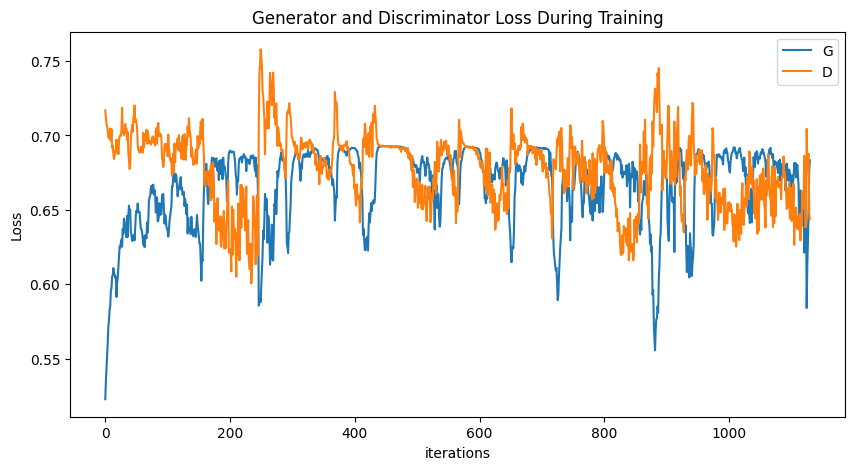

In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.utils import save_image


# Instantiate the models
generator = Generator(in_channels=3).to(device)
discriminator = Discriminator(in_channels=3).to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
opt_gen = Adam(generator.parameters(), lr=lr)
opt_disc = Adam(discriminator.parameters(), lr=lr)

disc_losses = []
gen_losses = []

# Training Loop
for epoch in range(num_epochs):
    for i, ((normal_imgs, _), (art_imgs, _)) in enumerate(zip(normal_loader, art_loader)):
        normal_imgs, art_imgs = normal_imgs.to(device), art_imgs.to(device)

        # Train Discriminator
        opt_disc.zero_grad()
        real_output = discriminator(art_imgs)
        real_loss = criterion(real_output, torch.ones_like(real_output))
        fake_imgs = generator(normal_imgs)
        fake_output = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        disc_loss = (real_loss + fake_loss) / 2
        disc_loss.backward()
        opt_disc.step()

        # Train Generator
        opt_gen.zero_grad()
        fake_imgs = generator(normal_imgs)
        output = discriminator(fake_imgs)
        gen_loss = criterion(output, torch.ones_like(output))
        gen_loss.backward()
        opt_gen.step()

        # Save the losses
        disc_losses.append(disc_loss.item())
        gen_losses.append(gen_loss.item())

        # Print losses
        if i % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Iteration {i}/{len(normal_loader)} - Loss D: {disc_loss:.4f}, Loss G: {gen_loss:.4f}")

        # Save sample images
        if i % 100 == 0:
            concatenated = torch.cat((normal_imgs[:4], fake_imgs[:4]), dim=2)  # Concatenate along width
            torchvision.utils.save_image(concatenated, f"{output_folder}/concatenated_{epoch}_{i}.png")

    # Save model weights
    torch.save(generator.state_dict(), f"{model_weights_folder}/generator_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"{model_weights_folder}/discriminator_{epoch}.pth")

#plot the losses:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="G")
plt.plot(disc_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
